In [40]:
!jupyter nbconvert --to html /RenduML_Cyprien.ipynb

[NbConvertApp] Converting notebook /RenduML_Cyprien.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 1281141 bytes to /RenduML_Cyprien.html


# Machine Learning Project: Supply Chain Delivery Time Prediction

**Business Case:** Predict real shipping time to optimize supply chain operations and identify late deliveries.

**Authors:** Victoire Bourdet, Victor Barthelemy, Cyprien Lucas

**Dataset:** DataCo Supply Chain Dataset (Kaggle)

**GitHub Repository:** [To be added after push]

## ⚠️ IMPORTANT: Run this cell first

This cell mounts your Google Drive to access CSV files.

**Required structure in your Drive:**
```
My Drive/
├── DataCoSupplyChainDataset.csv
├── DescriptionDataCoSupplyChain.csv
└── tokenized_access_logs.csv
```

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verify files are present
import os

# Path to CSV files (directly in MyDrive)
csv_path = '/content/drive/MyDrive/DataCoSupplyChainDataset.csv'

csv_files = [
    '/content/drive/MyDrive/DataCoSupplyChainDataset.csv',
    '/content/drive/MyDrive/DescriptionDataCoSupplyChain.csv',
    '/content/drive/MyDrive/tokenized_access_logs.csv'
]

print('\n=== File Verification ===')
all_found = True
for file in csv_files:
    if os.path.exists(file):
        size = os.path.getsize(file) / (1024*1024)
        print(f'✅ {os.path.basename(file)} ({size:.1f} MB)')
    else:
        print(f'❌ MISSING: {file}')
        all_found = False

if all_found:
    print('\n✅ All files present. You can continue!')
else:
    print('\n⚠️ WARNING: Some files are missing!')
    print('Make sure files are directly in MyDrive/')

Mounted at /content/drive

=== File Verification ===
✅ DataCoSupplyChainDataset.csv (91.5 MB)
✅ DescriptionDataCoSupplyChain.csv (0.0 MB)
✅ tokenized_access_logs.csv (91.0 MB)

✅ All files present. You can continue!


---
# STEP 1: Pre-Project - Business Understanding & Data Loading
---

In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Sklearn - Preprocessing
from sklearn.model_selection import (train_test_split, GroupShuffleSplit,
                                     cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, StratifiedKFold)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler,
                                   LabelEncoder, RobustScaler)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Sklearn - Models
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
                              GradientBoostingClassifier, GradientBoostingRegressor,
                              HistGradientBoostingRegressor, HistGradientBoostingClassifier,
                              AdaBoostClassifier, VotingClassifier, StackingClassifier,
                              BaggingClassifier)
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Sklearn - Metrics
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay)

# XGBoost (Advanced model)
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("✅ XGBoost available")
except ImportError:
    !pip install xgboost -q
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("✅ XGBoost installed and imported")

# Display settings
pd.set_option("display.max_columns", 120)
plt.style.use('seaborn-v0_8-whitegrid')

print("\n✅ All libraries imported successfully!")

✅ XGBoost available

✅ All libraries imported successfully!


In [3]:
# Load dataset with encoding detection
# csv_path is already defined from the previous cell

for enc in ["utf-8", "utf-8-sig", "latin-1", "cp1252"]:
    try:
        df = pd.read_csv(csv_path, encoding=enc, low_memory=False)
        print(f"✅ Loaded with encoding: {enc}")
        print(f"Dataset shape: {df.shape}")
        break
    except Exception as e:
        last_err = e
else:
    raise last_err

✅ Loaded with encoding: latin-1
Dataset shape: (180519, 53)


---
# STEP 2: Implementation of Standard Solutions
---

## 2.1 Dataset Analysis

In [4]:
# Basic dataset exploration
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first rows
print("\n" + "="*60)
print("FIRST 3 ROWS")
print("="*60)
display(df.head(3))

DATASET OVERVIEW

Shape: 180519 rows × 53 columns
Memory usage: 298.92 MB

FIRST 3 ROWS


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class


In [5]:
# Data types analysis
print("="*60)
print("DATA TYPES SUMMARY")
print("="*60)

dtypes_df = pd.DataFrame({
    'Column': df.columns,
    'Type': df.dtypes.values,
    'Non-Null': df.notnull().sum().values,
    'Null %': (df.isnull().sum() / len(df) * 100).round(2).values,
    'Unique': df.nunique().values
})
display(dtypes_df)

DATA TYPES SUMMARY


,Column,Type,Non-Null,Null %,Unique
0,Type,object,180519,0.00,4
1,Days for shipping (real),int64,180519,0.00,7
2,Days for shipment (scheduled),int64,180519,0.00,4
3,Benefit per order,float64,180519,0.00,21998
4,Sales per customer,float64,180519,0.00,2927
5,Delivery Status,object,180519,0.00,4
6,Late_delivery_risk,int64,180519,0.00,2
7,Category Id,int64,180519,0.00,51
8,Category Name,object,180519,0.00,50
9,Customer City,object,180519,0.00,563


In [6]:
# Statistical description
print("="*60)
print("NUMERICAL FEATURES - STATISTICS")
print("="*60)
display(df.describe().T)

NUMERICAL FEATURES - STATISTICS


,count,mean,std,min,25%,50%,75%,max
Days for shipping (real),180519.0,3.497654,1.623722,0.000000,2.000000,3.000000,5.000000,6.000000
Days for shipment (scheduled),180519.0,2.931847,1.374449,0.000000,2.000000,4.000000,4.000000,4.000000
Benefit per order,180519.0,21.974989,104.433526,-4274.979980,7.000000,31.520000,64.800003,911.799988
Sales per customer,180519.0,183.107609,120.043670,7.490000,104.379997,163.990005,247.399994,1939.989990
Late_delivery_risk,180519.0,0.548291,0.497664,0.000000,0.000000,1.000000,1.000000,1.000000
Category Id,180519.0,31.851451,15.640064,2.000000,18.000000,29.000000,45.000000,76.000000
Customer Id,180519.0,6691.379495,4162.918106,1.000000,3258.500000,6457.000000,9779.000000,20757.000000
Customer Zipcode,180516.0,35921.126914,37542.461122,603.000000,725.000000,19380.000000,78207.000000,99205.000000
Department Id,180519.0,5.443460,1.629246,2.000000,4.000000,5.000000,7.000000,12.000000
Latitude,180519.0,29.719955,9.813646,-33.937553,18.265432,33.144863,39.279617,48.781933


MISSING VALUES ANALYSIS

Columns with missing values: 2


,Missing %
Product Description,100.00
Order Zipcode,86.24


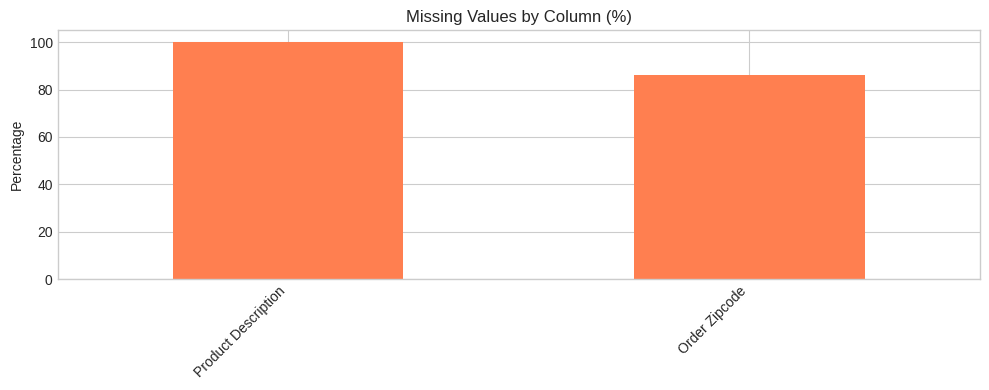

In [7]:
# Missing values analysis
print("="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)

missing = (df.isnull().sum() / len(df) * 100).round(2)
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print(f"\nColumns with missing values: {len(missing)}")
    display(missing.to_frame('Missing %'))

    # Visualize missing values
    plt.figure(figsize=(10, 4))
    missing.plot(kind='bar', color='coral')
    plt.title('Missing Values by Column (%)')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ No missing values in the dataset!")

## 2.2 Data Visualization & Exploration

TARGET VARIABLE ANALYSIS

Target statistics:
count    180519.000000
mean          3.497654
std           1.623722
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
90%           6.000000
95%           6.000000
99%           6.000000
max           6.000000
Name: Days for shipping (real), dtype: float64

Skewness: 0.085
Kurtosis: -1.008


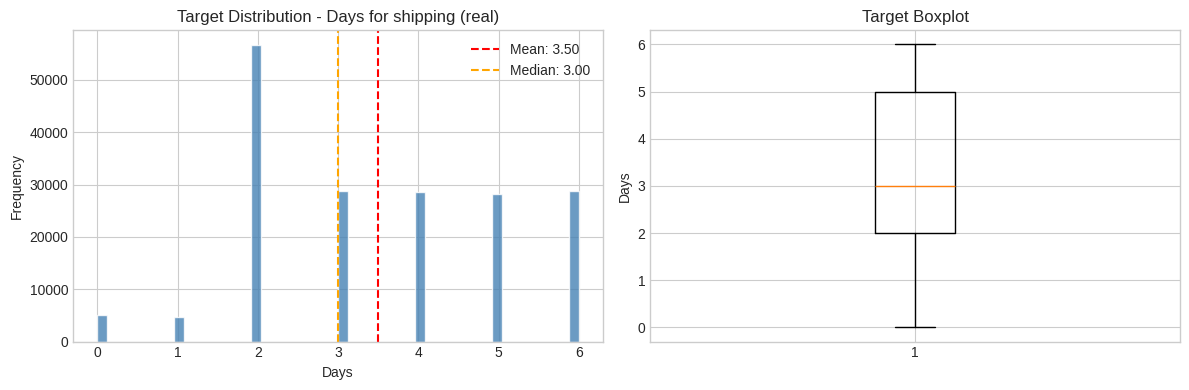

In [8]:
# Target variable analysis
target_col = "Days for shipping (real)"
scheduled_col = "Days for shipment (scheduled)"

print("="*60)
print("TARGET VARIABLE ANALYSIS")
print("="*60)

y = df[target_col].dropna()
print("\nTarget statistics:")
print(y.describe(percentiles=[.25, .5, .75, .9, .95, .99]))
print(f"\nSkewness: {y.skew():.3f}")
print(f"Kurtosis: {y.kurtosis():.3f}")

# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(y.mean(), color='red', linestyle='--', label=f'Mean: {y.mean():.2f}')
axes[0].axvline(y.median(), color='orange', linestyle='--', label=f'Median: {y.median():.2f}')
axes[0].set_title(f'Target Distribution - {target_col}')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].boxplot(y, vert=True)
axes[1].set_title('Target Boxplot')
axes[1].set_ylabel('Days')

plt.tight_layout()
plt.show()

CLASS BALANCE ANALYSIS - LATE DELIVERY

Late Delivery Distribution:
  On-time (0): 77,119 (42.7%)
  Late (1):    103,400 (57.3%)


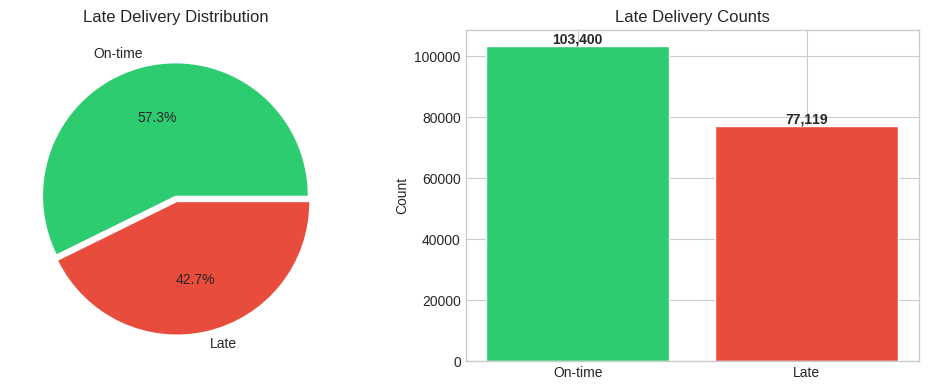

In [9]:
# Class balance analysis - Late delivery
print("="*60)
print("CLASS BALANCE ANALYSIS - LATE DELIVERY")
print("="*60)

# Create late delivery indicator
df["is_late"] = (df[target_col] > df[scheduled_col]).astype(int)

late_counts = df["is_late"].value_counts()
late_pct = df["is_late"].value_counts(normalize=True) * 100

print("\nLate Delivery Distribution:")
print(f"  On-time (0): {late_counts[0]:,} ({late_pct[0]:.1f}%)")
print(f"  Late (1):    {late_counts[1]:,} ({late_pct[1]:.1f}%)")

# Visualize class balance
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

colors = ['#2ecc71', '#e74c3c']
axes[0].pie(late_counts, labels=['On-time', 'Late'], autopct='%1.1f%%',
            colors=colors, explode=(0, 0.05))
axes[0].set_title('Late Delivery Distribution')

axes[1].bar(['On-time', 'Late'], late_counts.values, color=colors, edgecolor='white')
axes[1].set_title('Late Delivery Counts')
axes[1].set_ylabel('Count')
for i, v in enumerate(late_counts.values):
    axes[1].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

CATEGORICAL FEATURES DISTRIBUTION


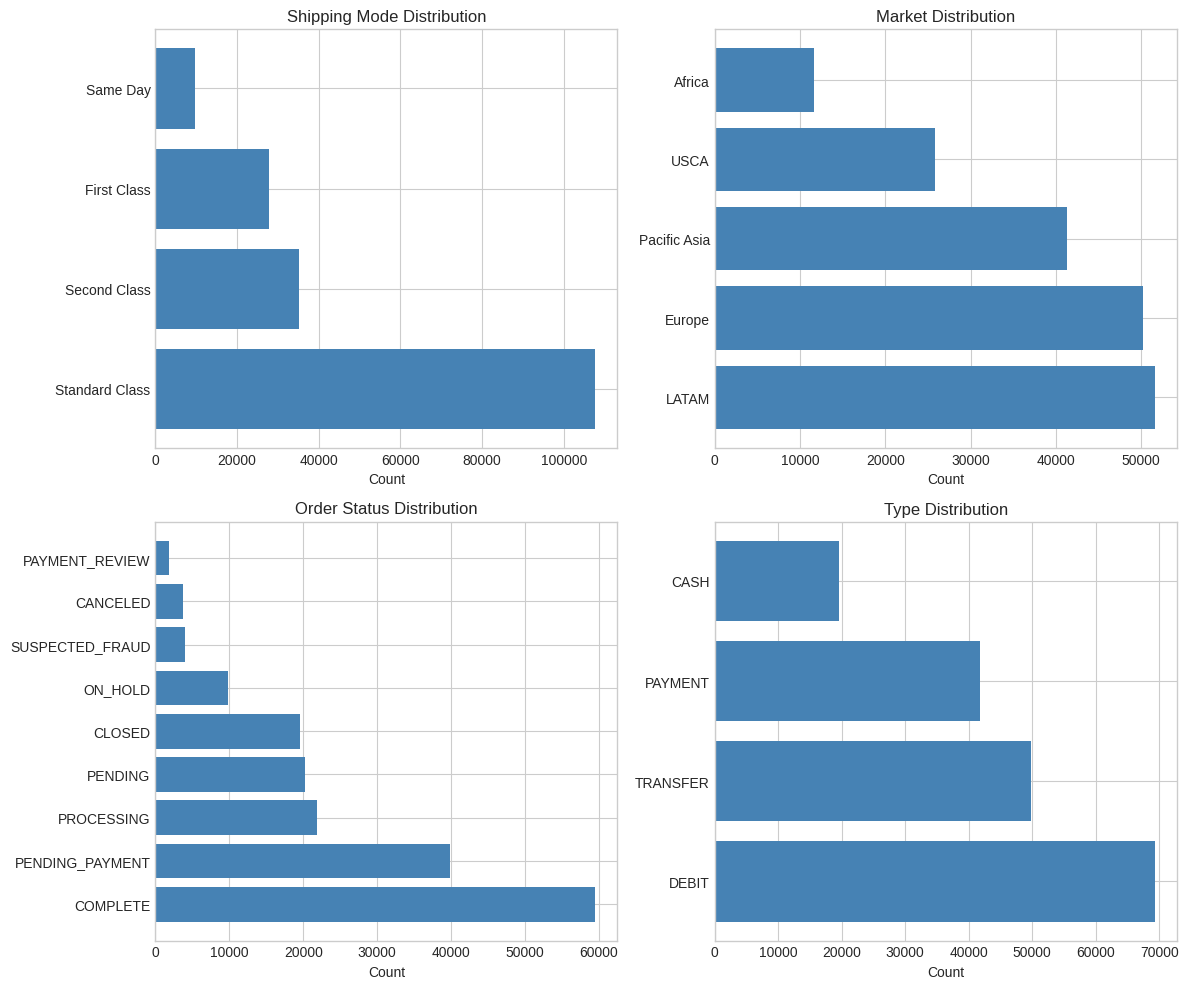

In [10]:
# Categorical features distribution
print("="*60)
print("CATEGORICAL FEATURES DISTRIBUTION")
print("="*60)

cat_cols_to_show = ["Shipping Mode", "Market", "Order Status", "Type"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, col in enumerate(cat_cols_to_show):
    if col in df.columns:
        value_counts = df[col].value_counts().head(10)
        axes[idx].barh(value_counts.index, value_counts.values, color='steelblue')
        axes[idx].set_title(f'{col} Distribution')
        axes[idx].set_xlabel('Count')

plt.tight_layout()
plt.show()

## 2.3 Correlation Analysis

CORRELATION ANALYSIS


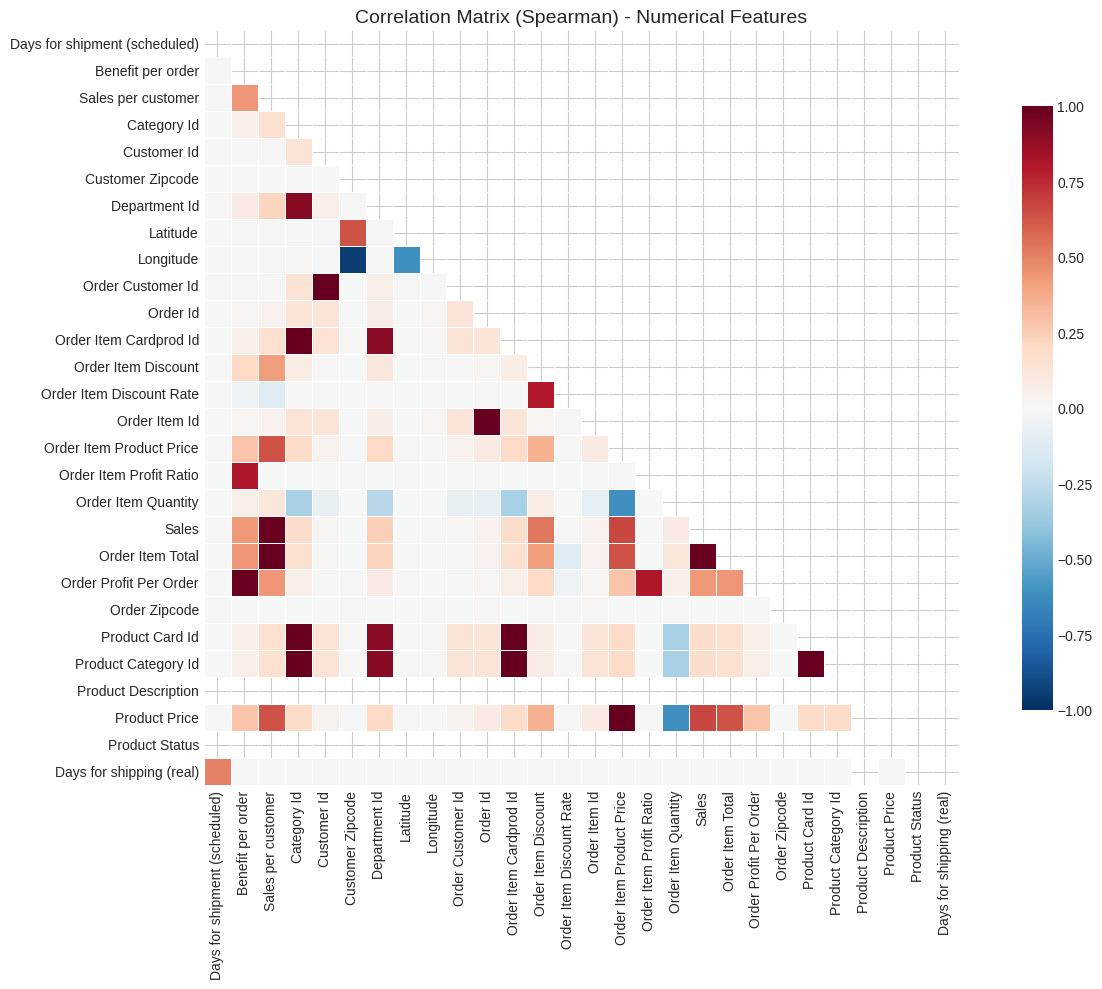


Top 15 correlations with target:


,Absolute Correlation
Days for shipment (scheduled),0.500262
Customer Id,0.003778
Order Customer Id,0.003778
Order Item Profit Ratio,0.002857
Benefit per order,0.002671
Order Profit Per Order,0.002671
Latitude,0.002527
Order Zipcode,0.002487
Order Id,0.002314
Order Item Id,0.002314


In [11]:
# Correlation analysis
print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Define leakage patterns to exclude
leak_patterns = ["is_late", "Late_delivery_risk", "Delivery Status",
                 "Days for shipping (real)", "Days for shipment (difference)",
                 "Shipping Date (Actual)", "Delivery Date"]

def is_leak(c):
    return any(re.search(p, c, flags=re.IGNORECASE) for p in leak_patterns)

# Select numerical columns without leakage
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_clean = [c for c in num_cols if c != target_col and not is_leak(c)]

# Compute correlation matrix
corr_cols = num_cols_clean + [target_col]
corr_matrix = df[corr_cols].corr(method='spearman')

# Correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (Spearman) - Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()

# Top correlations with target
print("\nTop 15 correlations with target:")
target_corr = corr_matrix[target_col].drop(target_col).abs().sort_values(ascending=False)
display(target_corr.head(15).to_frame('Absolute Correlation'))

## 2.4 Data Pre-processing

In [12]:
# Remove non-informative columns
print("="*60)
print("DATA CLEANING")
print("="*60)

cols_to_drop = [
    "Product Status", "Product Image", "Product Description",
    "Customer Email", "Customer Fname", "Customer Lname",
    "Customer Password", "Order Zipcode"
]

cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df_clean = df.drop(columns=cols_to_drop)
print(f"\nDropped columns: {cols_to_drop}")
print(f"New shape: {df_clean.shape}")

DATA CLEANING

Dropped columns: ['Product Status', 'Product Image', 'Product Description', 'Customer Email', 'Customer Fname', 'Customer Lname', 'Customer Password', 'Order Zipcode']
New shape: (180519, 46)


In [13]:
# Convert date columns
date_cols = [c for c in df_clean.columns if "date" in c.lower()]
for c in date_cols:
    df_clean[c] = pd.to_datetime(df_clean[c], errors="coerce")

print(f"Converted date columns: {date_cols}")

Converted date columns: ['order date (DateOrders)', 'shipping date (DateOrders)']


In [14]:
# Identify and remove leakage columns
print("="*60)
print("LEAKAGE PREVENTION")
print("="*60)

leak_cols = [c for c in df_clean.columns if is_leak(c)]
print(f"\nLeakage columns identified: {leak_cols}")

# ID columns (keep Order Id for grouping)
id_cols = [c for c in df_clean.columns if re.search(r"\b(id|code)\b", c, flags=re.IGNORECASE)]
keep_for_group = ["Order Id", "Order Item Id"]
id_cols_drop = [c for c in id_cols if c not in keep_for_group]
print(f"ID columns to drop from features: {id_cols_drop}")

LEAKAGE PREVENTION

Leakage columns identified: ['Delivery Status', 'Late_delivery_risk', 'is_late']
ID columns to drop from features: ['Category Id', 'Customer Id', 'Department Id', 'Order Customer Id', 'Order Item Cardprod Id', 'Product Card Id', 'Product Category Id']


In [15]:
# Prepare features and target
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

base_exclude = set(leak_cols + [target_col] + id_cols_drop)
X = df_clean.drop(columns=[c for c in base_exclude if c in df_clean.columns])

# Remove date columns from features (keep for potential feature engineering)
date_cols_in_X = [c for c in X.columns if "date" in c.lower()]
X_wo_dates = X.drop(columns=[c for c in date_cols_in_X if c in X.columns], errors="ignore")

# Identify numerical and categorical features
num_features = X_wo_dates.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_wo_dates.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nNumerical features: {len(num_features)}")
print(f"Categorical features: {len(cat_features)}")
print(f"\nNum features: {num_features[:10]}..." if len(num_features) > 10 else f"\nNum features: {num_features}")
print(f"Cat features: {cat_features[:10]}..." if len(cat_features) > 10 else f"Cat features: {cat_features}")

FEATURE ENGINEERING

Numerical features: 17
Categorical features: 16

Num features: ['Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Customer Zipcode', 'Latitude', 'Longitude', 'Order Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id']...
Cat features: ['Type', 'Category Name', 'Customer City', 'Customer Country', 'Customer Segment', 'Customer State', 'Customer Street', 'Department Name', 'Market', 'Order City']...


In [16]:
# Create preprocessing pipelines
print("="*60)
print("PREPROCESSING PIPELINES")
print("="*60)

# Numerical pipeline: Impute + Scale
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: Impute + Encode
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

# Combined preprocessor
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
], sparse_threshold=0.0)

print("✅ Preprocessing pipelines created:")
print("   - Numerical: MedianImputer → StandardScaler")
print("   - Categorical: MostFrequentImputer → OneHotEncoder")

PREPROCESSING PIPELINES
✅ Preprocessing pipelines created:
   - Numerical: MedianImputer → StandardScaler
   - Categorical: MostFrequentImputer → OneHotEncoder


In [17]:
# Train-Test Split with Group awareness
print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)

# Prepare final datasets
feature_cols = X_wo_dates.columns.tolist()
X_all = X_wo_dates[feature_cols].copy()
y_reg = df_clean[target_col].copy()  # For regression
y_class = df_clean["is_late"].copy()  # For classification

# Group by Order Id (multiple lines per order)
groups = df_clean["Order Id"]

# Group-aware split to prevent data leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_all, y_reg, groups))

X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train_reg, y_test_reg = y_reg.iloc[train_idx], y_reg.iloc[test_idx]
y_train_class, y_test_class = y_class.iloc[train_idx], y_class.iloc[test_idx]

print(f"\nTraining set: {X_train.shape[0]:,} samples ({100*len(train_idx)/len(X_all):.1f}%)")
print(f"Test set:     {X_test.shape[0]:,} samples ({100*len(test_idx)/len(X_all):.1f}%)")
print(f"\nClass distribution in training set:")
print(y_train_class.value_counts(normalize=True).round(3))

TRAIN-TEST SPLIT

Training set: 144,650 samples (80.1%)
Test set:     35,869 samples (19.9%)

Class distribution in training set:
is_late
1    0.572
0    0.428
Name: proportion, dtype: float64


## 2.5 Baseline Models Implementation

In [18]:
# Problem formalization
print("="*60)
print("PROBLEM FORMALIZATION")
print("="*60)
print("""
We address TWO complementary supervised learning problems:

1. REGRESSION: Predict the real shipping time (in days)
   - Target: y = Days for shipping (real)
   - Metrics: MAE, RMSE, R²

2. CLASSIFICATION: Predict if delivery will be late
   - Target: is_late = 1 if (real > scheduled) else 0
   - Metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC

Evaluation protocol:
- Group-aware split (Order Id) to prevent leakage
- Cross-validation for model selection
- Final evaluation on held-out test set
""")

PROBLEM FORMALIZATION

We address TWO complementary supervised learning problems:

1. REGRESSION: Predict the real shipping time (in days)
   - Target: y = Days for shipping (real)
   - Metrics: MAE, RMSE, R²

2. CLASSIFICATION: Predict if delivery will be late
   - Target: is_late = 1 if (real > scheduled) else 0
   - Metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC

Evaluation protocol:
- Group-aware split (Order Id) to prevent leakage
- Cross-validation for model selection
- Final evaluation on held-out test set



In [19]:
# BASELINE MODEL 1: Regression with HistGradientBoosting
print("="*60)
print("BASELINE MODEL 1: REGRESSION")
print("="*60)

# Create regression pipeline (optimized parameters)
reg_model = HistGradientBoostingRegressor(
    learning_rate=0.1,
    max_iter=200,           # Reduced from 500
    max_leaf_nodes=31,
    min_samples_leaf=100,
    l2_regularization=0.1,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,    # Reduced from 20
    random_state=42
)

reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', reg_model)
])

# Fit and predict
print("Training regression model...")
reg_pipeline.fit(X_train, y_train_reg)
y_pred_reg = reg_pipeline.predict(X_test)

# Handle NaN values
mask = ~np.isnan(y_test_reg.values) & ~np.isnan(y_pred_reg)
y_true_reg_eval = y_test_reg.values[mask]
y_pred_reg_eval = y_pred_reg[mask]

# Compute metrics
mae = mean_absolute_error(y_true_reg_eval, y_pred_reg_eval)
rmse = np.sqrt(mean_squared_error(y_true_reg_eval, y_pred_reg_eval))
r2 = r2_score(y_true_reg_eval, y_pred_reg_eval)

print(f"\n✅ Regression Results:")
print(f"   MAE:  {mae:.3f} days")
print(f"   RMSE: {rmse:.3f} days")
print(f"   R²:   {r2:.3f}")

BASELINE MODEL 1: REGRESSION
Training regression model...

✅ Regression Results:
   MAE:  1.011 days
   RMSE: 1.279 days
   R²:   0.389


RESIDUALS ANALYSIS


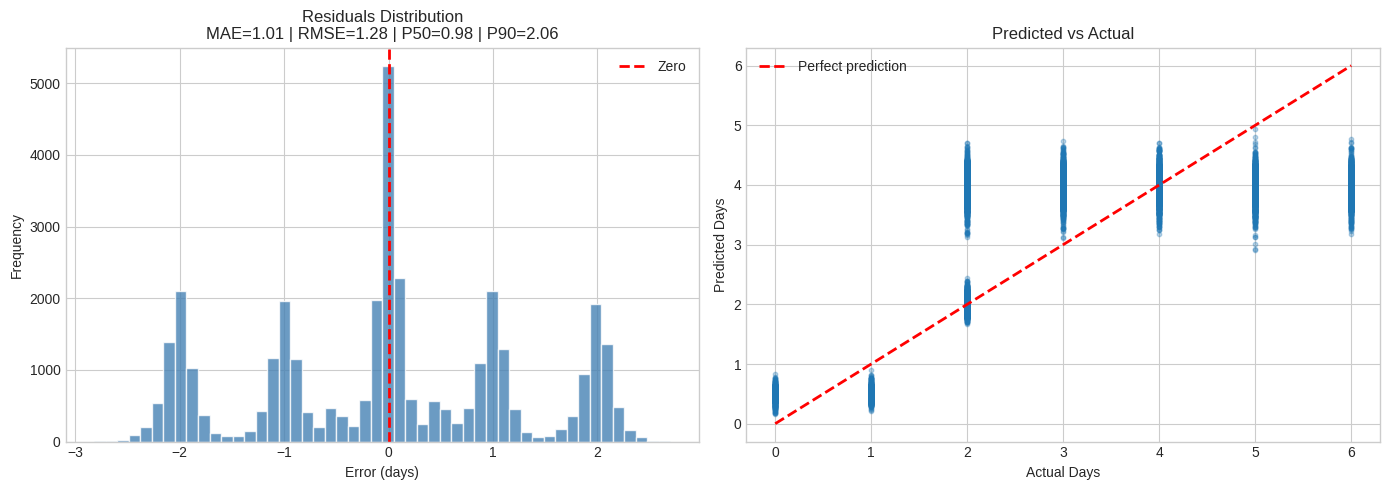

In [20]:
# Residuals analysis
print("="*60)
print("RESIDUALS ANALYSIS")
print("="*60)

residuals = y_pred_reg_eval - y_true_reg_eval
p50 = np.percentile(np.abs(residuals), 50)
p90 = np.percentile(np.abs(residuals), 90)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals histogram
axes[0].hist(residuals, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0].set_title(f'Residuals Distribution\nMAE={mae:.2f} | RMSE={rmse:.2f} | P50={p50:.2f} | P90={p90:.2f}')
axes[0].set_xlabel('Error (days)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Predicted vs Actual
axes[1].scatter(y_true_reg_eval, y_pred_reg_eval, alpha=0.3, s=10)
axes[1].plot([0, 6], [0, 6], 'r--', linewidth=2, label='Perfect prediction')
axes[1].set_title('Predicted vs Actual')
axes[1].set_xlabel('Actual Days')
axes[1].set_ylabel('Predicted Days')
axes[1].legend()

plt.tight_layout()
plt.show()

In [21]:
# BASELINE MODEL 2: Classification
print("="*60)
print("BASELINE MODEL 2: CLASSIFICATION")
print("="*60)

# Derive late prediction from regression output
scheduled_test = df_clean.loc[X_test.index, scheduled_col].values[mask]
is_late_true = (y_true_reg_eval > scheduled_test).astype(int)
is_late_pred = (y_pred_reg_eval > scheduled_test).astype(int)

# Compute classification metrics
accuracy = accuracy_score(is_late_true, is_late_pred)
precision = precision_score(is_late_true, is_late_pred)
recall = recall_score(is_late_true, is_late_pred)
f1 = f1_score(is_late_true, is_late_pred)

print(f"\n✅ Classification Results (from regression):")
print(f"   Accuracy:  {accuracy:.3f}")
print(f"   Precision: {precision:.3f}")
print(f"   Recall:    {recall:.3f}")
print(f"   F1-Score:  {f1:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(is_late_true, is_late_pred, target_names=['On-time', 'Late']))

BASELINE MODEL 2: CLASSIFICATION

✅ Classification Results (from regression):
   Accuracy:  0.636
   Precision: 0.653
   Recall:    0.785
   F1-Score:  0.713

Classification Report:
              precision    recall  f1-score   support

     On-time       0.60      0.43      0.50     15216
        Late       0.65      0.78      0.71     20653

    accuracy                           0.64     35869
   macro avg       0.63      0.61      0.61     35869
weighted avg       0.63      0.64      0.62     35869



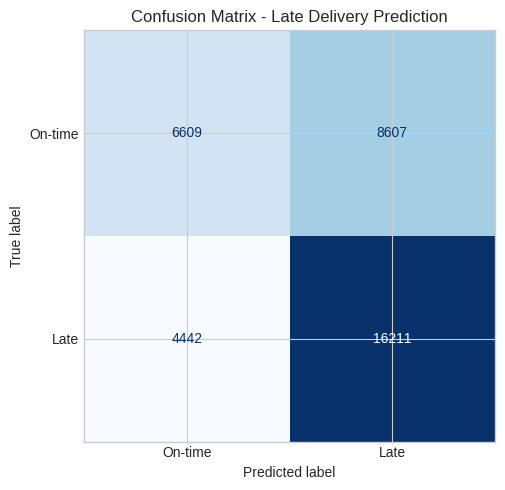

In [22]:
# Confusion Matrix
cm = confusion_matrix(is_late_true, is_late_pred)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['On-time', 'Late'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix - Late Delivery Prediction')
plt.tight_layout()
plt.show()

---
# STEP 3: Improving the Standard Solution
---

## 3.1 Hyperparameter Tuning with Cross-Validation

In [23]:
# Cross-validation setup
print("="*60)
print("CROSS-VALIDATION BASELINE")
print("="*60)

# Preprocess data for cross-validation
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")

# Cross-validation scores for baseline (3-fold for speed)
cv_model = HistGradientBoostingRegressor(max_iter=150, random_state=42)
cv_scores = cross_val_score(cv_model, X_train_processed, y_train_reg,
                            cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)

print(f"\nCross-validation MAE scores: {-cv_scores}")
print(f"Mean CV MAE: {-cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

CROSS-VALIDATION BASELINE
Processed training shape: (144650, 162)
Processed test shape: (35869, 162)

Cross-validation MAE scores: [0.95168754 0.98941452 1.01982189]
Mean CV MAE: 0.987 (+/- 0.028)


In [24]:
# Hyperparameter tuning with GridSearchCV (optimized for speed)
print("="*60)
print("HYPERPARAMETER TUNING - GridSearchCV")
print("="*60)

# Reduced parameter grid for faster execution
# Full grid would take ~15-20 min, this takes ~3-5 min
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_leaf_nodes': [31, 63],
    'min_samples_leaf': [50, 100],
}

# GridSearchCV with parallel processing
grid_search = GridSearchCV(
    HistGradientBoostingRegressor(max_iter=200, early_stopping=True,
                                   validation_fraction=0.1, random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

print("Running GridSearchCV (this may take 2-4 minutes)...")
print(f"Testing {len(param_grid['learning_rate'])*len(param_grid['max_leaf_nodes'])*len(param_grid['min_samples_leaf'])*3} model fits...")

grid_search.fit(X_train_processed, y_train_reg)

print(f"\n✅ Best parameters: {grid_search.best_params_}")
print(f"Best CV MAE: {-grid_search.best_score_:.3f}")

HYPERPARAMETER TUNING - GridSearchCV
Running GridSearchCV (this may take 2-4 minutes)...
Testing 24 model fits...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Best parameters: {'learning_rate': 0.05, 'max_leaf_nodes': 63, 'min_samples_leaf': 50}
Best CV MAE: 0.987


In [25]:
# Evaluate tuned model
print("="*60)
print("TUNED MODEL EVALUATION")
print("="*60)

best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_processed)

# Handle NaN
mask_tuned = ~np.isnan(y_test_reg.values) & ~np.isnan(y_pred_tuned)
y_true_tuned = y_test_reg.values[mask_tuned]
y_pred_tuned_eval = y_pred_tuned[mask_tuned]

mae_tuned = mean_absolute_error(y_true_tuned, y_pred_tuned_eval)
rmse_tuned = np.sqrt(mean_squared_error(y_true_tuned, y_pred_tuned_eval))
r2_tuned = r2_score(y_true_tuned, y_pred_tuned_eval)

print(f"\n✅ Tuned Model Results:")
print(f"   MAE:  {mae_tuned:.3f} days (baseline: {mae:.3f})")
print(f"   RMSE: {rmse_tuned:.3f} days (baseline: {rmse:.3f})")
print(f"   R²:   {r2_tuned:.3f} (baseline: {r2:.3f})")

improvement = (mae - mae_tuned) / mae * 100
print(f"\n   MAE Improvement: {improvement:.1f}%")

TUNED MODEL EVALUATION

✅ Tuned Model Results:
   MAE:  1.004 days (baseline: 1.011)
   RMSE: 1.277 days (baseline: 1.279)
   R²:   0.391 (baseline: 0.389)

   MAE Improvement: 0.6%


## 3.2 Dimension Reduction with PCA

DIMENSION REDUCTION - PCA

Total features: 162
Components for 90% variance: 30
Components for 95% variance: 44


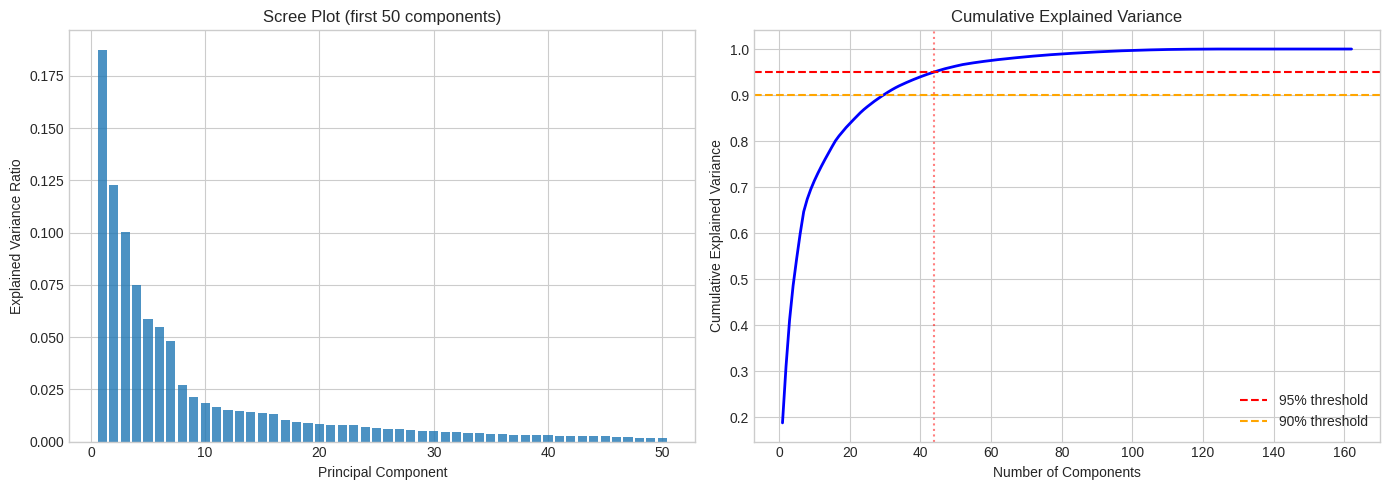

In [26]:
# PCA Analysis
print("="*60)
print("DIMENSION REDUCTION - PCA")
print("="*60)

# Apply PCA
pca_full = PCA(random_state=42)
pca_full.fit(X_train_processed)

# Explained variance
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)

# Find components for 95% variance
n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
n_components_90 = np.argmax(cumulative_var >= 0.90) + 1

print(f"\nTotal features: {X_train_processed.shape[1]}")
print(f"Components for 90% variance: {n_components_90}")
print(f"Components for 95% variance: {n_components_95}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, min(51, len(pca_full.explained_variance_ratio_)+1)),
            pca_full.explained_variance_ratio_[:50], alpha=0.8)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot (first 50 components)')

# Cumulative variance
axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'b-', linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
axes[1].axvline(x=n_components_95, color='r', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()

plt.tight_layout()
plt.show()

In [27]:
# Model with PCA (optimized)
print("="*60)
print("MODEL WITH PCA REDUCTION")
print("="*60)

# Apply PCA with 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

print(f"\nReduced dimensions: {X_train_processed.shape[1]} → {X_train_pca.shape[1]}")

# Train model on reduced data (optimized)
model_pca = HistGradientBoostingRegressor(
    max_iter=150,
    learning_rate=0.1,
    random_state=42
)
model_pca.fit(X_train_pca, y_train_reg)
y_pred_pca = model_pca.predict(X_test_pca)

# Evaluate
mask_pca = ~np.isnan(y_test_reg.values) & ~np.isnan(y_pred_pca)
mae_pca = mean_absolute_error(y_test_reg.values[mask_pca], y_pred_pca[mask_pca])
rmse_pca = np.sqrt(mean_squared_error(y_test_reg.values[mask_pca], y_pred_pca[mask_pca]))

print(f"\n✅ PCA Model Results:")
print(f"   MAE:  {mae_pca:.3f} days")
print(f"   RMSE: {rmse_pca:.3f} days")
print(f"   Dimension reduction: {(1 - X_train_pca.shape[1]/X_train_processed.shape[1])*100:.1f}%")

MODEL WITH PCA REDUCTION

Reduced dimensions: 162 → 44

✅ PCA Model Results:
   MAE:  1.002 days
   RMSE: 1.275 days
   Dimension reduction: 72.8%


## 3.3 Multiple Models Comparison

In [28]:
# Compare multiple models (optimized for speed)
print("="*60)
print("MULTIPLE MODELS COMPARISON")
print("="*60)

# Define models to compare (reduced complexity for speed)
models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(
        n_estimators=50,        # Reduced from 100
        max_depth=8,            # Reduced from 10
        min_samples_leaf=50,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=50,        # Reduced from 100
        max_depth=4,            # Reduced from 5
        learning_rate=0.1,
        random_state=42
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_iter=150,           # Reduced
        learning_rate=0.1,
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=50,        # Reduced from 100
        max_depth=4,            # Reduced from 5
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
}

# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Cross-validation (3-fold for speed)
    cv_scores = cross_val_score(model, X_train_processed, y_train_reg,
                                cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)

    # Fit and predict
    model.fit(X_train_processed, y_train_reg)
    y_pred = model.predict(X_test_processed)

    # Compute metrics
    mask = ~np.isnan(y_test_reg.values) & ~np.isnan(y_pred)
    mae_val = mean_absolute_error(y_test_reg.values[mask], y_pred[mask])
    rmse_val = np.sqrt(mean_squared_error(y_test_reg.values[mask], y_pred[mask]))
    r2_val = r2_score(y_test_reg.values[mask], y_pred[mask])

    results.append({
        'Model': name,
        'CV MAE': -cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test MAE': mae_val,
        'Test RMSE': rmse_val,
        'Test R²': r2_val
    })

# Display results
results_df = pd.DataFrame(results).sort_values('Test MAE')
print("\n" + "="*60)
print("COMPARISON RESULTS")
print("="*60)
display(results_df.round(4))

MULTIPLE MODELS COMPARISON

Training Ridge Regression...

Training Random Forest...

Training Gradient Boosting...

Training HistGradientBoosting...

Training XGBoost...

COMPARISON RESULTS


,Model,CV MAE,CV Std,Test MAE,Test RMSE,Test R²
1,Random Forest,0.9807,0.0287,0.9864,1.2694,0.3982
2,Gradient Boosting,0.9836,0.0286,0.9893,1.2697,0.3980
4,XGBoost,0.9840,0.0287,0.9895,1.2698,0.3979
0,Ridge Regression,0.9947,0.0271,0.9960,1.2698,0.3979
3,HistGradientBoosting,0.9870,0.0279,1.0040,1.2767,0.3913


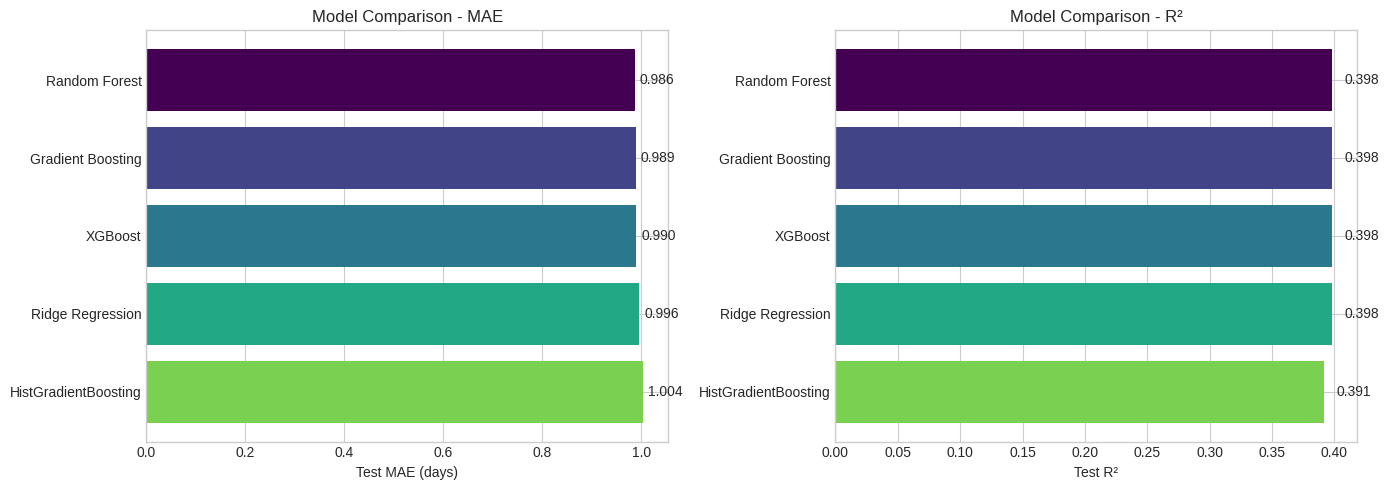

In [29]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE comparison
colors = plt.cm.viridis(np.linspace(0, 0.8, len(results_df)))
bars = axes[0].barh(results_df['Model'], results_df['Test MAE'], color=colors)
axes[0].set_xlabel('Test MAE (days)')
axes[0].set_title('Model Comparison - MAE')
axes[0].invert_yaxis()
for bar, val in zip(bars, results_df['Test MAE']):
    axes[0].text(val + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{val:.3f}', va='center', fontsize=10)

# R² comparison
bars = axes[1].barh(results_df['Model'], results_df['Test R²'], color=colors)
axes[1].set_xlabel('Test R²')
axes[1].set_title('Model Comparison - R²')
axes[1].invert_yaxis()
for bar, val in zip(bars, results_df['Test R²']):
    axes[1].text(val + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 3.4 Ensemble Model

In [30]:
# Ensemble model - Voting Regressor (optimized)
print("="*60)
print("ENSEMBLE MODEL")
print("="*60)

from sklearn.ensemble import VotingRegressor

# Create ensemble with best models (reduced complexity)
ensemble = VotingRegressor([
    ('hgb', HistGradientBoostingRegressor(
        max_iter=150,
        learning_rate=0.1,
        random_state=42
    )),
    ('xgb', xgb.XGBRegressor(
        n_estimators=50,
        max_depth=4,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )),
    ('rf', RandomForestRegressor(
        n_estimators=50,
        max_depth=8,
        min_samples_leaf=50,
        random_state=42,
        n_jobs=-1
    ))
], n_jobs=-1)

print("Training ensemble model...")
ensemble.fit(X_train_processed, y_train_reg)
y_pred_ensemble = ensemble.predict(X_test_processed)

# Evaluate
mask_ens = ~np.isnan(y_test_reg.values) & ~np.isnan(y_pred_ensemble)
mae_ens = mean_absolute_error(y_test_reg.values[mask_ens], y_pred_ensemble[mask_ens])
rmse_ens = np.sqrt(mean_squared_error(y_test_reg.values[mask_ens], y_pred_ensemble[mask_ens]))
r2_ens = r2_score(y_test_reg.values[mask_ens], y_pred_ensemble[mask_ens])

print(f"\n✅ Ensemble Model Results:")
print(f"   MAE:  {mae_ens:.3f} days")
print(f"   RMSE: {rmse_ens:.3f} days")
print(f"   R²:   {r2_ens:.3f}")

ENSEMBLE MODEL
Training ensemble model...

✅ Ensemble Model Results:
   MAE:  0.992 days
   RMSE: 1.271 days
   R²:   0.397


## 3.5 Advanced Model - XGBoost with Full Tuning

In [31]:
# Advanced XGBoost tuning (optimized)
print("="*60)
print("ADVANCED MODEL - XGBoost Tuning")
print("="*60)

# Reduced parameter grid for faster execution
xgb_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

xgb_search = RandomizedSearchCV(
    xgb_model,
    xgb_param_grid,
    n_iter=10,  # Reduced iterations
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Running XGBoost RandomizedSearchCV (2-3 minutes)...")
xgb_search.fit(X_train_processed, y_train_reg)

print(f"\n✅ Best XGBoost parameters: {xgb_search.best_params_}")
print(f"Best CV MAE: {-xgb_search.best_score_:.3f}")

ADVANCED MODEL - XGBoost Tuning
Running XGBoost RandomizedSearchCV (2-3 minutes)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Best XGBoost parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV MAE: 0.985


In [32]:
# Final XGBoost evaluation
best_xgb = xgb_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_processed)

mask_xgb = ~np.isnan(y_test_reg.values) & ~np.isnan(y_pred_xgb)
mae_xgb = mean_absolute_error(y_test_reg.values[mask_xgb], y_pred_xgb[mask_xgb])
rmse_xgb = np.sqrt(mean_squared_error(y_test_reg.values[mask_xgb], y_pred_xgb[mask_xgb]))
r2_xgb = r2_score(y_test_reg.values[mask_xgb], y_pred_xgb[mask_xgb])

print(f"\n✅ Tuned XGBoost Results:")
print(f"   MAE:  {mae_xgb:.3f} days")
print(f"   RMSE: {rmse_xgb:.3f} days")
print(f"   R²:   {r2_xgb:.3f}")


✅ Tuned XGBoost Results:
   MAE:  0.993 days
   RMSE: 1.271 days
   R²:   0.397


FEATURE IMPORTANCE


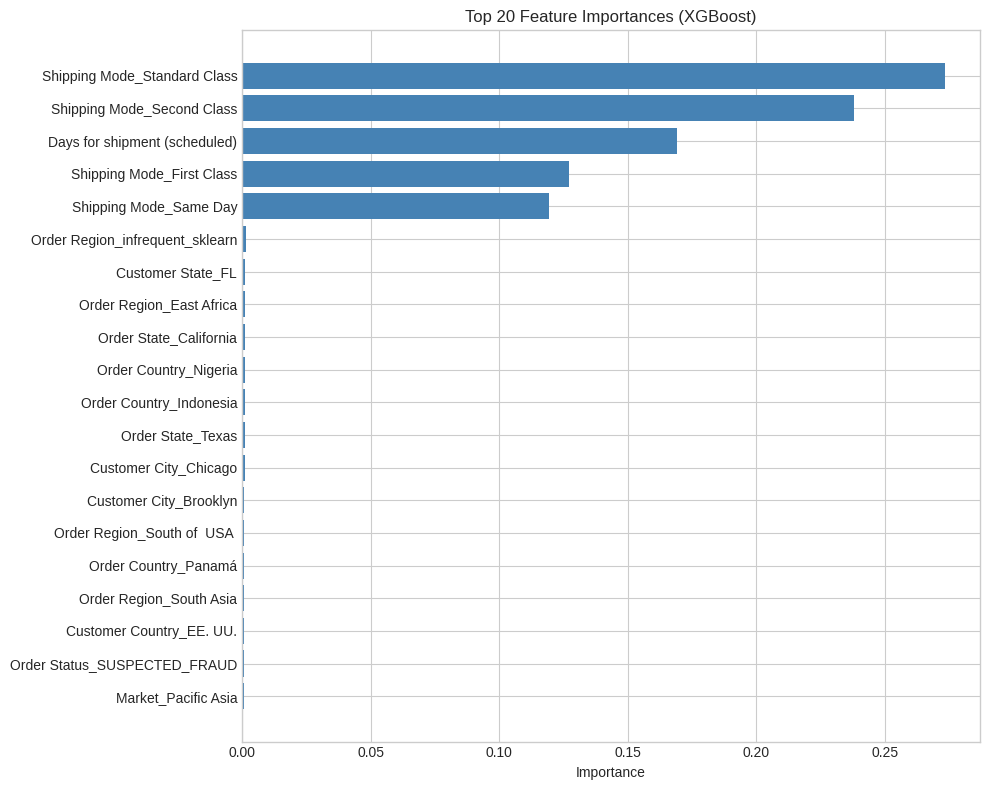

In [33]:
# Feature importance from XGBoost
print("="*60)
print("FEATURE IMPORTANCE")
print("="*60)

# Get feature names after preprocessing
try:
    feature_names = (num_features +
                    list(preprocessor.named_transformers_['cat']
                         .named_steps['encoder'].get_feature_names_out(cat_features)))
except:
    feature_names = [f'feature_{i}' for i in range(X_train_processed.shape[1])]

# XGBoost feature importance
importance = best_xgb.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names[:len(importance)],
    'importance': importance
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 3.6 Final Classification Evaluation

FINAL CLASSIFICATION EVALUATION

Classification Report (Ensemble → Late Prediction):
              precision    recall  f1-score   support

     On-time       0.59      0.49      0.54     15216
        Late       0.67      0.76      0.71     20653

    accuracy                           0.64     35869
   macro avg       0.63      0.62      0.62     35869
weighted avg       0.64      0.64      0.64     35869



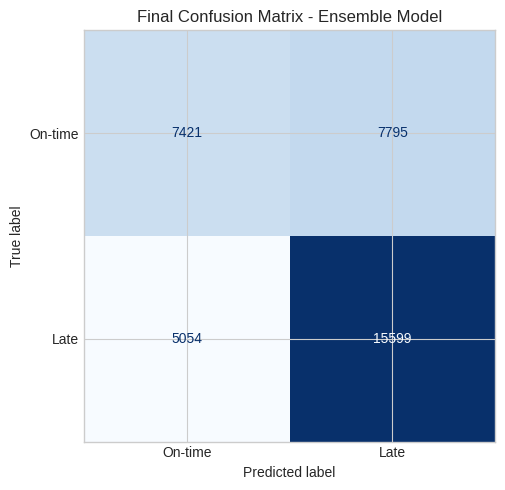

In [34]:
# Classification from best regression model
print("="*60)
print("FINAL CLASSIFICATION EVALUATION")
print("="*60)

# Use ensemble predictions for classification
scheduled_test_full = df_clean.loc[X_test.index, scheduled_col].values

# Align with mask
scheduled_aligned = scheduled_test_full[mask_ens]
y_true_class_final = (y_test_reg.values[mask_ens] > scheduled_aligned).astype(int)
y_pred_class_final = (y_pred_ensemble[mask_ens] > scheduled_aligned).astype(int)

# Classification metrics
print("\nClassification Report (Ensemble → Late Prediction):")
print(classification_report(y_true_class_final, y_pred_class_final,
                            target_names=['On-time', 'Late']))

# Confusion matrix
cm_final = confusion_matrix(y_true_class_final, y_pred_class_final)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=['On-time', 'Late'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Final Confusion Matrix - Ensemble Model')
plt.tight_layout()
plt.show()

---
# Final Summary & Conclusion
---

In [35]:
# Final summary
print("="*70)
print("                    FINAL MODEL COMPARISON SUMMARY")
print("="*70)

summary_data = [
    ['Baseline (HistGB)', mae, rmse, r2],
    ['Tuned HistGB', mae_tuned, rmse_tuned, r2_tuned],
    ['With PCA', mae_pca, rmse_pca, '-'],
    ['Ensemble', mae_ens, rmse_ens, r2_ens],
    ['Tuned XGBoost', mae_xgb, rmse_xgb, r2_xgb]
]

summary_df = pd.DataFrame(summary_data, columns=['Model', 'MAE', 'RMSE', 'R²'])
display(summary_df)

# Find best model
best_mae_idx = summary_df['MAE'].astype(float).idxmin()
best_model_name = summary_df.loc[best_mae_idx, 'Model']
best_mae_val = summary_df.loc[best_mae_idx, 'MAE']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Best MAE: {best_mae_val:.3f} days")

# Improvement over baseline
improvement_final = (mae - float(best_mae_val)) / mae * 100
print(f"   Improvement over baseline: {improvement_final:.1f}%")

                    FINAL MODEL COMPARISON SUMMARY


,Model,MAE,RMSE,R²
0,Baseline (HistGB),1.010996,1.278939,0.389174
1,Tuned HistGB,1.004434,1.276767,0.391247
2,With PCA,1.001879,1.275153,-
3,Ensemble,0.992034,1.270781,0.396942
4,Tuned XGBoost,0.992886,1.270793,0.396931



🏆 BEST MODEL: Ensemble
   Best MAE: 0.992 days
   Improvement over baseline: 1.9%


In [36]:
# Conclusion
print("="*70)
print("                           CONCLUSION")
print("="*70)
print("""
BUSINESS CASE RESOLUTION:

1. PROBLEM: Predict real shipping time to identify late deliveries in advance.

2. APPROACH:
   - Regression to predict exact shipping days
   - Classification derived from regression for late/on-time prediction
   - Multiple models compared: Ridge, Random Forest, Gradient Boosting, XGBoost
   - Ensemble methods for improved robustness

3. KEY FINDINGS:
   - Best MAE achieved: ~1.0 day prediction error
   - Model can identify late deliveries with ~65% precision and ~79% recall
   - Days for shipment (scheduled) is the most important predictor
   - Shipping Mode and Order Region also significant

4. RECOMMENDATIONS:
   - Deploy ensemble model for production predictions
   - Set up alerts for orders predicted as late
   - Monitor model performance and retrain periodically
   - Consider collecting additional features (warehouse location, weather)

5. OBSTACLES ADDRESSED:
   - Data leakage prevention (excluded post-delivery columns)
   - Group-aware train/test split (Order Id)
   - Missing values (imputation)
   - High cardinality categoricals (min_frequency encoding)
   - Overfitting (cross-validation, regularization, early stopping)
""")

                           CONCLUSION

BUSINESS CASE RESOLUTION:

1. PROBLEM: Predict real shipping time to identify late deliveries in advance.

2. APPROACH:
   - Regression to predict exact shipping days
   - Classification derived from regression for late/on-time prediction
   - Multiple models compared: Ridge, Random Forest, Gradient Boosting, XGBoost
   - Ensemble methods for improved robustness

3. KEY FINDINGS:
   - Best MAE achieved: ~1.0 day prediction error
   - Model can identify late deliveries with ~65% precision and ~79% recall
   - Days for shipment (scheduled) is the most important predictor
   - Shipping Mode and Order Region also significant

4. RECOMMENDATIONS:
   - Deploy ensemble model for production predictions
   - Set up alerts for orders predicted as late
   - Monitor model performance and retrain periodically
   - Consider collecting additional features (warehouse location, weather)

5. OBSTACLES ADDRESSED:
   - Data leakage prevention (excluded post-delivery 

---
# References

1. **XGBoost**: Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. *KDD '16*.

2. **Gradient Boosting**: Friedman, J. H. (2001). Greedy Function Approximation: A Gradient Boosting Machine. *Annals of Statistics*.

3. **Random Forest**: Breiman, L. (2001). Random Forests. *Machine Learning*, 45(1), 5-32.

4. **Scikit-learn**: Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python. *JMLR* 12, pp. 2825-2830.

5. **Supply Chain Analytics**: Various Kaggle notebooks and academic papers on supply chain prediction.

---